In [606]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sms
import statsmodels.stats.api as sts
import statsmodels.formula.api as statsmodels
import pylab

from scipy.stats import shapiro
from scipy.stats import zscore
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [607]:
FCI=pd.read_csv(r'C:\Users\user\Desktop\Food Demand\Train/fulfilment_center_info.csv')

In [608]:
MI=pd.read_csv(r'C:\Users\user\Desktop\Food Demand\Train\meal_info.csv')

In [609]:
Train=pd.read_csv(r'C:\Users\user\Desktop\Food Demand\Train\train.csv')

In [610]:
Test=pd.read_csv('test_QoiMO9B.csv')

In [611]:
FCI.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [612]:
MI.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [613]:
Train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [614]:
Train.shape

(456548, 9)

In [615]:
Train=Train.merge(FCI, how='inner', on='center_id')

In [616]:
Train=Train.merge(MI, how='inner', on='meal_id')

In [617]:
Test=Test.merge(FCI, how='inner', on='center_id')

In [618]:
Test=Test.merge(MI, how='inner', on='meal_id')

In [619]:
Train.shape

(456548, 15)

In [620]:
Test.shape

(32573, 14)

In [621]:
Train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [622]:
Train['S']='Train'
Test['S']='Test'

In [623]:
Train=pd.concat([Train,Test])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [624]:
Train.shape

(489121, 16)

In [625]:
Train.isnull().sum()

S                            0
base_price                   0
category                     0
center_id                    0
center_type                  0
checkout_price               0
city_code                    0
cuisine                      0
emailer_for_promotion        0
homepage_featured            0
id                           0
meal_id                      0
num_orders               32573
op_area                      0
region_code                  0
week                         0
dtype: int64

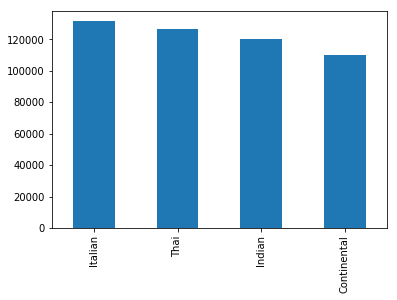

In [626]:
Train['cuisine'].value_counts().plot(kind='bar')
plt.show()

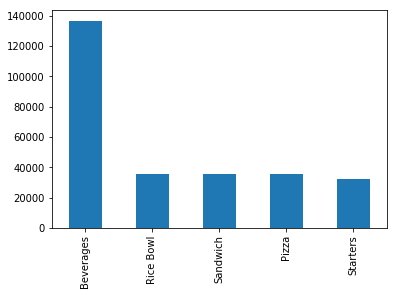

In [627]:
#Top 5 Cartegory
Train['category'].value_counts().sort_values(ascending=False).head(5).plot(kind='bar')
plt.show()

In [628]:
Train['Discount%']=(Train['base_price']-Train['checkout_price'])*100/(Train['base_price'])

In [629]:
Train['Profit']=Train['checkout_price']-Train['base_price']

In [630]:
#Top 5 Discount
Train[['cuisine','Discount%']].sort_values(by='Discount%', ascending=False).head(5)

,cuisine,Discount%
112240,Continental,99.060870
160195,Indian,82.370821
59225,Indian,81.984757
49200,Indian,81.206808
368402,Thai,79.625858


In [631]:
#Where there is no discount
Train[['cuisine','Discount%']].sort_values(by='Discount%', ascending=True).head(5)

,cuisine,Discount%
48613,Indian,-72.789753
58662,Indian,-68.009894
58661,Indian,-67.224319
48612,Indian,-67.224319
116281,Continental,-57.189593


In [632]:
#Top 5 cuisine on base price and there discount
Train[['base_price','cuisine','Discount%']].sort_values(by='base_price', ascending=False).head(5)

,base_price,cuisine,Discount%
25382,1112.62,Italian,-0.089878
25383,1112.62,Italian,73.752944
25386,1111.62,Italian,69.628110
25385,1111.62,Italian,69.718069
25384,1111.62,Italian,69.808028


In [633]:
#lowest base price with there Discount
Train[['base_price','cuisine', 'Discount%']].sort_values(by='base_price', ascending=True).head(5)

,base_price,cuisine,Discount%
238750,55.35,Thai,0.000000
231393,64.02,Thai,-3.124024
54075,65.02,Indian,1.537988
238244,66.02,Thai,1.514693
45547,72.75,Indian,-32.000000


In [634]:
Train.head()

,S,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week,Discount%,Profit
0,Train,152.29,Beverages,55,TYPE_C,136.83,647,Thai,0,0,1379560,1885,177.0,2.0,56,1,10.151684,-15.46
1,Train,152.29,Beverages,55,TYPE_C,135.83,647,Thai,0,0,1018704,1885,323.0,2.0,56,2,10.808326,-16.46
2,Train,133.92,Beverages,55,TYPE_C,132.92,647,Thai,0,0,1196273,1885,96.0,2.0,56,3,0.746714,-1.00
3,Train,134.86,Beverages,55,TYPE_C,135.86,647,Thai,0,0,1116527,1885,163.0,2.0,56,4,-0.741510,1.00
4,Train,147.50,Beverages,55,TYPE_C,146.50,647,Thai,0,0,1343872,1885,215.0,2.0,56,5,0.677966,-1.00


In [635]:
Train.groupby('week')['Profit'].sum().sort_values(ascending=False).head(5)

week
155   -15036.10
154   -15710.49
43    -25581.39
102   -26529.11
146   -27344.41
Name: Profit, dtype: float64

In [636]:
Train.groupby('week')['Profit'].sum().sort_values(ascending=True).head(5)

week
123   -144035.80
91    -129749.16
85    -128801.15
90    -126604.55
122   -126366.06
Name: Profit, dtype: float64

In [637]:
#highest orders with relation to centre id
pd.DataFrame(Train.groupby('center_id')['num_orders'].sum().sort_values(ascending =False)).head(5)

,num_orders
center_id,
13,4296545.0
43,3920294.0
10,3381018.0
52,3125835.0
137,3117478.0


In [638]:
#lowest orders with relation to centre id
pd.DataFrame(Train.groupby('center_id')['num_orders'].sum().sort_values(ascending =True)).head(5)

,num_orders
center_id,
91,425160.0
41,497338.0
149,637527.0
162,680255.0
74,691044.0


In [639]:
#top 5 region with there num of orders
pd.DataFrame(Train.groupby('region_code')['num_orders'].sum().sort_values(ascending=False).head(5))

,num_orders
region_code,
56,60520191.0
34,24051733.0
77,20529653.0
85,8685386.0
71,2103282.0


In [640]:
#lowest 5 region with there num of orders
pd.DataFrame(Train.groupby('region_code')['num_orders'].sum().sort_values(ascending=True).head(5))

,num_orders
region_code,
35,691044.0
93,1366290.0
23,1609906.0
71,2103282.0
85,8685386.0


In [641]:
#Top 5 city with there num of orders
pd.DataFrame(Train.groupby('city_code')['num_orders'].sum().sort_values(ascending=False).head(5))

,num_orders
city_code,
590,19849062.0
526,9207953.0
638,6662450.0
604,3533367.0
522,3375905.0


In [642]:
#Lowest 5 city with there num of orders
pd.DataFrame(Train.groupby('city_code')['num_orders'].sum().sort_values(ascending=True).head(5))

,num_orders
city_code,
478,637527.0
702,691044.0
693,743148.0
541,768013.0
658,813948.0


In [643]:
#Top five acroding to the city, region and center
pd.DataFrame(Train.groupby(['city_code','region_code','center_id'])['num_orders'].sum().sort_values(ascending=False).head(5))

num_orders
city_code region_code center_id            
590       56          13          4296545.0
                      43          3920294.0
                      10          3381018.0
685       56          52          3125835.0
590       56          137         3117478.0

In [644]:
#lowest five according to the city, region and center
pd.DataFrame(Train.groupby(['city_code','region_code', 'center_id'])['num_orders'].sum().sort_values(ascending=True).head(5))

num_orders
city_code region_code center_id            
590       56          91           425160.0
                      41           497338.0
478       77          149          637527.0
526       34          162          680255.0
702       35          74           691044.0

In [645]:
#Top 5 order no in week
pd.DataFrame(Train.groupby('week')['num_orders'].sum().sort_values(ascending=False).head(5))

,num_orders
week,
48,1303457.0
5,1198675.0
60,1131459.0
53,1108236.0
100,1088162.0


In [646]:
#Lowest 5 order no in week
pd.DataFrame(Train.groupby('week')['num_orders'].sum().sort_values(ascending=True).head(5))

,num_orders
week,
155,0.0
147,0.0
148,0.0
149,0.0
150,0.0


In [647]:
A=pd.DataFrame(Train.groupby('week')['base_price','checkout_price'].sum())

In [648]:
A['Discount']=(A['base_price']-A['checkout_price'])*100/A['base_price']

In [649]:
#Top 5 week accroding to price
pd.DataFrame(Train.groupby('week')['checkout_price'].sum().sort_values(ascending=False).head(5))

,checkout_price
week,
118,1140144.83
105,1138084.07
141,1133461.40
117,1132047.49
120,1131995.17


In [650]:
#lowest 5 week accroding to price
pd.DataFrame(Train.groupby('week')['checkout_price'].sum().sort_values(ascending=True).head(5))

,checkout_price
week,
5,901141.58
6,912920.01
8,919479.78
62,921837.04
9,923631.46


In [651]:
#lowest five discount in the week
A.sort_values(by='Discount', ascending=True).head(5)

,base_price,checkout_price,Discount
week,,,
155,1128641.53,1113605.43,1.332230
154,1142313.30,1126602.81,1.375322
43,1079119.99,1053538.60,2.370579
146,1152084.86,1124740.45,2.373472
102,1099548.65,1073019.54,2.412727


In [652]:
#top five orders according to mealid
pd.DataFrame(Train.groupby('meal_id')['num_orders'].sum().sort_values(ascending=False).head(5))

,num_orders
meal_id,
2290,9770303.0
1885,8346246.0
1754,6818059.0
1993,6656856.0
1109,6367773.0


In [653]:
#lowest five orders according to mealid
pd.DataFrame(Train.groupby('meal_id')['num_orders'].sum().sort_values(ascending=True).head(5))

,num_orders
meal_id,
2104,159957.0
1770,190709.0
1902,209242.0
1247,231897.0
1847,277635.0


In [654]:
Train['emailer_for_promotion'].unique()

array([0, 1], dtype=int64)

In [655]:
Train.groupby('homepage_featured')['num_orders'].sum()

homepage_featured
0    89899504.0
1    29657981.0
Name: num_orders, dtype: float64

In [656]:
Train.groupby('emailer_for_promotion')['num_orders'].sum()

emailer_for_promotion
0    96175321.0
1    23382164.0
Name: num_orders, dtype: float64

In [657]:
#Top 5 Category in related with order
Train.groupby('category')['num_orders'].sum().sort_values(ascending=False).head(5)

category
Beverages    40480525.0
Rice Bowl    20874063.0
Sandwich     17636782.0
Salad        10944336.0
Pizza         7383720.0
Name: num_orders, dtype: float64

In [658]:
#lowest 5 Category in related with order
Train.groupby('category')['num_orders'].sum().sort_values(ascending=True).head(5)

category
Biryani     631848.0
Fish        871959.0
Soup       1039646.0
Pasta      1637744.0
Desert     1940754.0
Name: num_orders, dtype: float64

In [659]:
Train.groupby('week')['category'].value_counts()

week  category    
1     Beverages       887
      Pizza           231
      Rice Bowl       231
      Sandwich        230
      Pasta           212
      Desert          210
      Starters        209
      Other Snacks    198
      Biryani         175
      Seafood         166
      Extras           94
      Soup             79
2     Beverages       886
      Pizza           230
      Rice Bowl       230
      Sandwich        229
      Starters        211
      Pasta           209
      Desert          203
      Other Snacks    196
      Seafood         168
      Biryani         159
      Extras           93
      Soup             82
3     Beverages       884
      Rice Bowl       231
      Sandwich        230
      Pizza           227
      Pasta           210
      Starters        208
                     ... 
153   Extras          102
      Soup             97
154   Beverages       896
      Salad           231
      Pizza           230
      Rice Bowl       230
      Sandwich     

In [660]:
Train.groupby('center_type')['num_orders'].sum().sort_values(ascending=False)

center_type
TYPE_A    68978517.0
TYPE_B    29996073.0
TYPE_C    20582895.0
Name: num_orders, dtype: float64

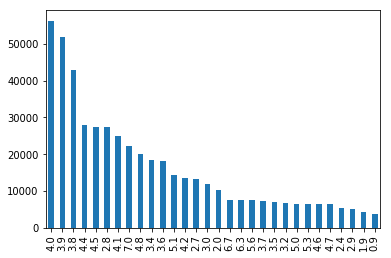

In [661]:
Train['op_area'].value_counts().plot(kind='bar')
plt.show()

In [662]:
Train.groupby('op_area')['num_orders'].sum().sort_values(ascending=False).head(5)

op_area
4.0    11780398.0
3.9    10738365.0
4.4     8367833.0
4.5     8043504.0
3.8     7977964.0
Name: num_orders, dtype: float64

In [663]:
Train.groupby('op_area')['num_orders'].sum().sort_values(ascending=True).head(5)

op_area
0.9     425160.0
1.9     497338.0
2.4     637527.0
2.9     898613.0
3.2    1218319.0
Name: num_orders, dtype: float64

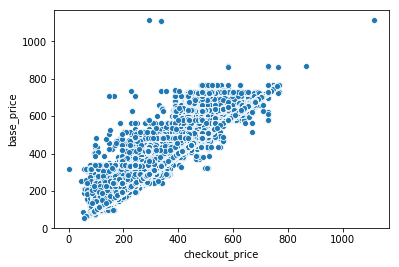

In [664]:
sns.scatterplot(Train['checkout_price'], Train['base_price'])
plt.show()

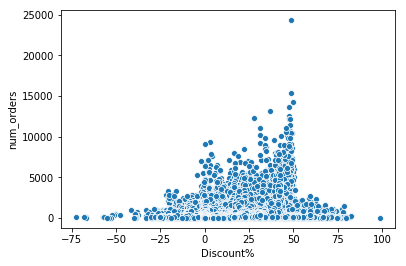

In [665]:
sns.scatterplot(x=Train['Discount%'], y=Train['num_orders'])
plt.show()

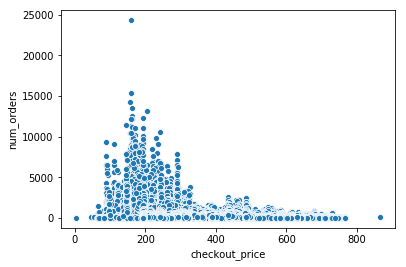

In [666]:
sns.scatterplot(x=Train['checkout_price'], y=Train['num_orders'] )

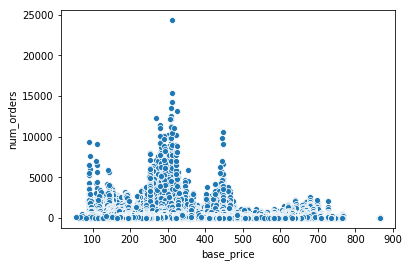

In [667]:
sns.scatterplot(x=Train['base_price'], y=Train['num_orders'])

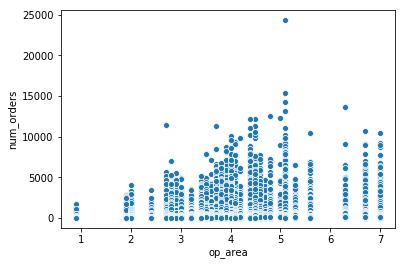

In [668]:
sns.scatterplot(Train['op_area'], Train['num_orders'])

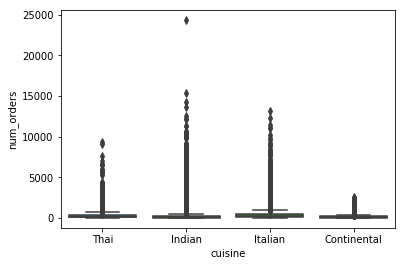

In [669]:
sns.boxplot(x=Train['cuisine'], y=Train['num_orders'])

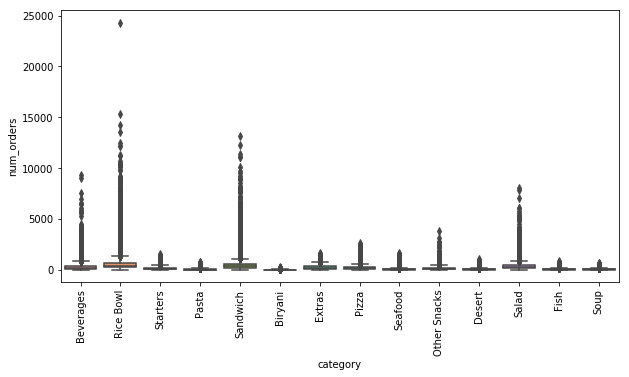

In [670]:
plt.figure(figsize=(10,5))
sns.boxplot(x=Train['category'], y=Train['num_orders'])
plt.xticks(rotation=90)
plt.show()

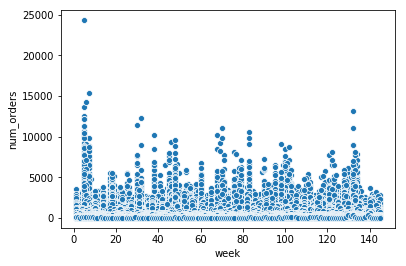

In [671]:
sns.scatterplot(Train['week'], Train['num_orders'])

#### Stats

In [672]:
Train.head()

,S,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week,Discount%,Profit
0,Train,152.29,Beverages,55,TYPE_C,136.83,647,Thai,0,0,1379560,1885,177.0,2.0,56,1,10.151684,-15.46
1,Train,152.29,Beverages,55,TYPE_C,135.83,647,Thai,0,0,1018704,1885,323.0,2.0,56,2,10.808326,-16.46
2,Train,133.92,Beverages,55,TYPE_C,132.92,647,Thai,0,0,1196273,1885,96.0,2.0,56,3,0.746714,-1.00
3,Train,134.86,Beverages,55,TYPE_C,135.86,647,Thai,0,0,1116527,1885,163.0,2.0,56,4,-0.741510,1.00
4,Train,147.50,Beverages,55,TYPE_C,146.50,647,Thai,0,0,1343872,1885,215.0,2.0,56,5,0.677966,-1.00


In [673]:
model=ols('num_orders~cuisine',data=Train).fit()

In [674]:
print(sms.stats.anova_lm(model))

                df        sum_sq       mean_sq            F  PR(>F)
cuisine        3.0  2.288127e+09  7.627091e+08  5026.286988     0.0
Residual  456544.0  6.927783e+10  1.517440e+05          NaN     NaN


In [675]:
model= ols('week ~ num_orders', data=Train).fit()

In [676]:
print(sms.stats.anova_lm(model))

                  df        sum_sq        mean_sq           F        PR(>F)
num_orders       1.0  2.331639e+05  233163.906360  135.260395  2.925458e-31
Residual    456546.0  7.870009e+08    1723.815066         NaN           NaN


In [677]:
model=ols('num_orders~center_type',data=Train).fit()

In [678]:
print(sms.stats.anova_lm(model))

                   df        sum_sq       mean_sq            F  PR(>F)
center_type       2.0  6.090329e+08  3.045165e+08  1959.293834     0.0
Residual     456545.0  7.095693e+10  1.554215e+05          NaN     NaN


In [679]:
Train.head()

,S,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week,Discount%,Profit
0,Train,152.29,Beverages,55,TYPE_C,136.83,647,Thai,0,0,1379560,1885,177.0,2.0,56,1,10.151684,-15.46
1,Train,152.29,Beverages,55,TYPE_C,135.83,647,Thai,0,0,1018704,1885,323.0,2.0,56,2,10.808326,-16.46
2,Train,133.92,Beverages,55,TYPE_C,132.92,647,Thai,0,0,1196273,1885,96.0,2.0,56,3,0.746714,-1.00
3,Train,134.86,Beverages,55,TYPE_C,135.86,647,Thai,0,0,1116527,1885,163.0,2.0,56,4,-0.741510,1.00
4,Train,147.50,Beverages,55,TYPE_C,146.50,647,Thai,0,0,1343872,1885,215.0,2.0,56,5,0.677966,-1.00


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


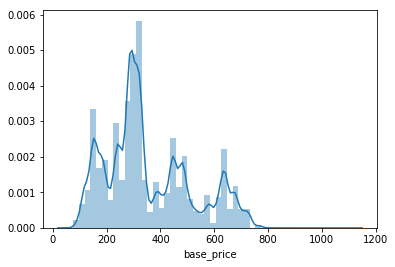

In [680]:
sns.distplot(Train['base_price'])

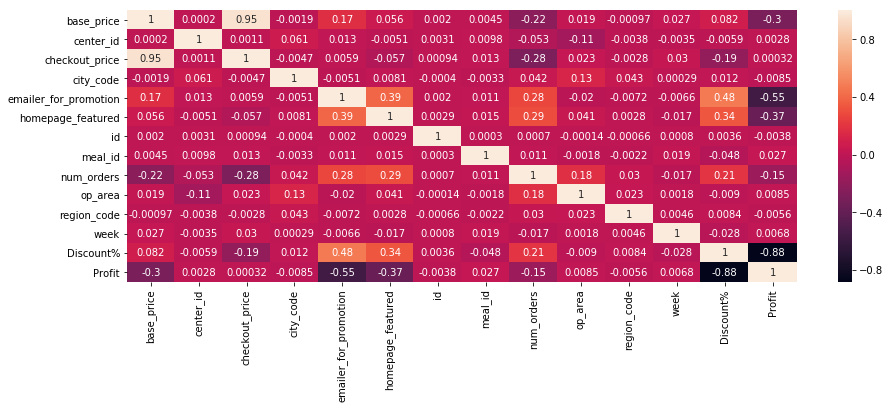

In [681]:
plt.figure(figsize=[15,5])
sns.heatmap(Train.corr(), annot=True)
plt.show()

In [682]:
Train.head()

,S,base_price,category,center_id,center_type,checkout_price,city_code,cuisine,emailer_for_promotion,homepage_featured,id,meal_id,num_orders,op_area,region_code,week,Discount%,Profit
0,Train,152.29,Beverages,55,TYPE_C,136.83,647,Thai,0,0,1379560,1885,177.0,2.0,56,1,10.151684,-15.46
1,Train,152.29,Beverages,55,TYPE_C,135.83,647,Thai,0,0,1018704,1885,323.0,2.0,56,2,10.808326,-16.46
2,Train,133.92,Beverages,55,TYPE_C,132.92,647,Thai,0,0,1196273,1885,96.0,2.0,56,3,0.746714,-1.00
3,Train,134.86,Beverages,55,TYPE_C,135.86,647,Thai,0,0,1116527,1885,163.0,2.0,56,4,-0.741510,1.00
4,Train,147.50,Beverages,55,TYPE_C,146.50,647,Thai,0,0,1343872,1885,215.0,2.0,56,5,0.677966,-1.00


In [683]:
Train.drop(['center_id','city_code','id','meal_id','region_code','base_price','Profit','week'],axis=1,inplace=True)

In [684]:
Train.head()

,S,category,center_type,checkout_price,cuisine,emailer_for_promotion,homepage_featured,num_orders,op_area,Discount%
0,Train,Beverages,TYPE_C,136.83,Thai,0,0,177.0,2.0,10.151684
1,Train,Beverages,TYPE_C,135.83,Thai,0,0,323.0,2.0,10.808326
2,Train,Beverages,TYPE_C,132.92,Thai,0,0,96.0,2.0,0.746714
3,Train,Beverages,TYPE_C,135.86,Thai,0,0,163.0,2.0,-0.741510
4,Train,Beverages,TYPE_C,146.50,Thai,0,0,215.0,2.0,0.677966


In [685]:
def f(x):
    if x> 0:
        return('Discount')
    else:
        return('No_Discount')

In [686]:
Train['Discount%']=Train['Discount%'].apply(f)

In [687]:
Train.head()

,S,category,center_type,checkout_price,cuisine,emailer_for_promotion,homepage_featured,num_orders,op_area,Discount%
0,Train,Beverages,TYPE_C,136.83,Thai,0,0,177.0,2.0,Discount
1,Train,Beverages,TYPE_C,135.83,Thai,0,0,323.0,2.0,Discount
2,Train,Beverages,TYPE_C,132.92,Thai,0,0,96.0,2.0,Discount
3,Train,Beverages,TYPE_C,135.86,Thai,0,0,163.0,2.0,No_Discount
4,Train,Beverages,TYPE_C,146.50,Thai,0,0,215.0,2.0,Discount


In [688]:
Train['Discount%'].unique()

array(['Discount', 'No_Discount'], dtype=object)

In [689]:
train=Train[Train['S']=='Train']
test=Train[Train['S']=='Test']

In [690]:
train.shape

(456548, 10)

In [691]:
test.shape

(32573, 10)

In [692]:
train.head()

,S,category,center_type,checkout_price,cuisine,emailer_for_promotion,homepage_featured,num_orders,op_area,Discount%
0,Train,Beverages,TYPE_C,136.83,Thai,0,0,177.0,2.0,Discount
1,Train,Beverages,TYPE_C,135.83,Thai,0,0,323.0,2.0,Discount
2,Train,Beverages,TYPE_C,132.92,Thai,0,0,96.0,2.0,Discount
3,Train,Beverages,TYPE_C,135.86,Thai,0,0,163.0,2.0,No_Discount
4,Train,Beverages,TYPE_C,146.50,Thai,0,0,215.0,2.0,Discount


In [693]:
train.drop('S',axis=1,inplace=True)
test.drop(['S','num_orders'],axis=1,inplace=True)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [694]:
train.shape

(456548, 9)

In [695]:
test.shape

(32573, 8)

In [696]:
Traindummy=pd.get_dummies(train, drop_first=True)
Testdummy=pd.get_dummies(test,drop_first=True)

In [697]:
Traindummy.shape

(456548, 24)

In [698]:
Testdummy.shape

(32573, 23)

In [699]:
x=Traindummy.drop('num_orders', axis=1)

In [700]:
y=Traindummy.num_orders

In [701]:
rc=RobustScaler()

In [702]:
x_scaled=rc.fit_transform(x)

In [703]:
Test_scaled=rc.transform(Testdummy)

In [704]:
lr=LinearRegression()

In [705]:
yhat=lr.fit(x_scaled,y).predict(Test_scaled)

In [706]:
sample=pd.read_csv('sample_submission_hSlSoT6 (1).csv')

In [707]:
sample.drop('num_orders',axis=1,inplace=True)

In [708]:
sample['num_orders']=yhat

In [709]:
sample.to_csv('lr.csv',index=False)

In [710]:
from sklearn.ensemble import RandomForestRegressor

In [711]:
rfr=RandomForestRegressor()

In [712]:
ypre=rfr.fit(x_scaled,y).predict(Test_scaled)

In [713]:
sample['num_orders']=ypre

In [714]:
sample.to_csv('RF.csv',index=False)

In [715]:
from sklearn.ensemble import GradientBoostingRegressor

In [716]:
gbr=GradientBoostingRegressor()

In [717]:
ypre=gbr.fit(x_scaled,y).predict(Test_scaled)

In [718]:
sample['num_orders']=ypre

In [719]:
sample.to_csv('GB.csv',index=False)

In [720]:
from sklearn.ensemble import AdaBoostRegressor

In [721]:
ab=AdaBoostRegressor()

In [722]:
ypre=ab.fit(x_scaled,y).predict(Test_scaled)

In [723]:
sample['num_orders']=ypre

In [724]:
sample.to_csv('ABR.csv',index=False)

In [725]:
from sklearn.neighbors import KNeighborsRegressor

In [739]:
Knn=KNeighborsRegressor()

In [740]:
ypre=Knn.fit(x_scaled,y).predict(Test_scaled)

In [741]:
sample['num_orders']=ypre

In [742]:
sample.to_csv('KNN.csv',index=False)

159.86